#  **SQL 데이터를 활용한 질문/응답(Q&A) 시스템 구축**

LLM(대규모 언어 모델) 시스템이 **구조화된 데이터(structured data)** 를 쿼리하도록 만드는 것은 **비구조화된 텍스트(unstructured text data)** 를 처리하는 것과는 상당히 다른 접근 방식이 필요합니다.

- **비구조화된 데이터:** 주로 벡터 데이터베이스를 사용하여 텍스트를 검색합니다.  
- **구조화된 데이터:** LLM이 SQL과 같은 언어를 사용하여 **쿼리(query)**를 작성하고 실행합니다.

다음 두 가지 구현 방식을 다룹니다:  
1. **체인(Chains)**
2. **에이전트(Agents)**

이 시스템을 통해 **데이터베이스에 대한 질문을 자연어로 입력**하고, **자연어로 답변을 받을 수 있습니다.**

- **체인:** 단일 SQL 쿼리를 실행하여 답변을 생성합니다.  
- **에이전트:** 필요에 따라 여러 번 데이터베이스를 쿼리하여 답변을 생성합니다.
---

## **아키텍처 (Architecture)**

1. **질문을 SQL 쿼리로 변환:**  
   - 모델이 사용자 입력을 SQL 쿼리로 변환합니다.  
<p></p>
2. **SQL 쿼리 실행:**  
   - 변환된 SQL 쿼리를 데이터베이스에서 실행합니다.  
<p></p>
3. **질문에 답변:**  
   - 모델이 SQL 쿼리 결과를 바탕으로 사용자 질문에 대한 답변을 생성합니다.  

<img src="https://python.langchain.com/assets/images/sql_usecase-d432701261f05ab69b38576093718cf3.png" />

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적 설정 활성화
os.environ["LANGSMITH_TRACING"] = "true"

### **샘플 데이터**

이 예제에서는 **SQLite** 연결을 사용하여 **Chinook 데이터베이스**를 활용합니다.  
Chinook 데이터베이스는 **디지털 미디어 스토어**를 나타내는 샘플 데이터베이스입니다.

---

##  **Chinook 데이터베이스 설치**

[설치 가이드](https://database.guide/2-sample-databases-sqlite/)를 따라 `Chinook.db`를 현재 노트북과 같은 디렉터리에 생성합니다.  

또는, 아래 명령어를 사용하여 커맨드 라인에서 데이터베이스를 다운로드하고 빌드할 수 있습니다:

```bash
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```

### **설명:**  
1. `curl` 명령어를 사용하여 Chinook 데이터베이스 SQL 스크립트를 다운로드합니다.  
2. `sqlite3`를 사용해 SQL 스크립트를 실행하고 `Chinook.db` 파일을 생성합니다.

---
이 데이터베이스는 **SQLAlchemy 기반의 `SQLDatabase` 클래스**를 사용하여 상호작용할 수 있습니다.

In [3]:
# SQLite3 설치 in Colab
# !sudo apt-get update
# !sudo apt-get install sqlite3

In [4]:
# Chinook db 설치 in Colab
# !curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

In [5]:
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스 파일 'Chinook.db'에 연결합니다.
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# 사용 중인 데이터베이스의 SQL 방언(SQL Dialect)을 출력합니다.
print(db.dialect)

# 데이터베이스에서 사용할 수 있는 테이블 이름들을 출력합니다.
print(db.get_usable_table_names())

result = db.run("SELECT * FROM Artist LIMIT 10;")
result

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

##  **SQL 데이터베이스를 LLM과 연결하기**

##  **1) 체인(Chains) 사용 방식**

**체인(Chains)** 은 예측 가능한 단계들의 조합입니다.  
**LangGraph**에서는 체인을 간단한 **노드들의 순서(sequence of nodes)** 로 표현할 수 있습니다.

주어진 질문에 대해 다음 단계를 수행하는 일련의 단계를 LangGraph를 이용하여 만들어 보겠습니다:  

- 질문을 **SQL 쿼리로 변환**합니다.  
- 쿼리를 **실행**합니다.  
- 쿼리 **결과를 사용해 원래 질문에 답변**합니다.  

---

이 구조에서는 다음과 같은 시나리오를 지원하지 않습니다:  

1. 이 시스템은 모든 사용자 입력에 대해 SQL 쿼리를 실행합니다.  
   - 예: `"hello"`라는 입력에도 SQL 쿼리를 실행합니다.  
2. 일부 질문은 **여러 개의 쿼리**가 필요할 수 있습니다.  

이러한 시나리오는 **에이전트(Agents)** 를 이용하여 구현해야 합니다.

---

#### **애플리케이션 상태(Application State)**

LangGraph의 **상태(State)** 는 애플리케이션에 입력되는 데이터, 단계 간에 전달되는 데이터, 그리고 출력되는 데이터를 제어합니다.  

- 일반적으로 `TypedDict`로 정의됩니다.  
- 또는, [**Pydantic BaseModel**](https://langchain-ai.github.io/langgraph/how-tos/state-model/)을 사용할 수도 있습니다.

애플리케이션 상태에서는 다음 데이터를 추적합니다:  

1. **입력된 질문 (Input Question)**  
2. **생성된 SQL 쿼리 (Generated Query)**  
3. **쿼리 결과 (Query Result)**  
4. **생성된 답변 (Generated Answer)**  

In [6]:
from typing_extensions import TypedDict, Annotated

# State 정의
class State(TypedDict):
    question: str    # 사용자로부터 입력받은 질문
    query: str         # 질문을 변환하여 생성된 SQL 쿼리
    result: str         # SQL 쿼리 실행 결과
    answer: str      # 최종적으로 생성된 LLM 답변

이제 이 상태(state)를 기반으로 작동하며 내용을 채워주는 **함수**들이 필요합니다.

---

#### **질문을 SQL 쿼리로 변환하기**

첫 번째 단계는 **사용자 입력을 SQL 쿼리로 변환**하는 것입니다.  
SQL 쿼리를 신뢰성 있게 생성하기 위해 LangChain의 **구조화된 출력(structured output)** 추상화를 사용할 것입니다.

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

---------
이 프롬프트에는 **SQL 방언(dialect)** 과 **테이블 정보(table_info)** 와 같은 채워야 할 여러 매개변수들이 포함되어 있습니다.  

LangChain의 [`SQLDatabase`](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) 객체에는 이러한 작업을 도와주는 메서드들이 포함되어 있습니다.  

우리의 `write_query` 단계는 이 매개변수들을 채운 뒤, **모델을 프롬프트하여 SQL 쿼리를 생성**하도록 할 것입니다.

In [9]:
from langchain_core.prompts import ChatPromptTemplate

# SQL 쿼리 프롬프트 템플릿 정의
query_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 SQL 전문가입니다. 주어진 질문을 SQL 쿼리로 변환하는 작업을 수행합니다.
    다음 정보를 참고하여 SQL 쿼리를 작성하세요:
    
    방언(dialect): {dialect}
    테이블 정보: {table_info}
    최대 결과 수: {top_k}
    
    쿼리는 문법적으로 정확해야 하며, 질문에 대한 정확한 답을 제공해야 합니다."""),
    ("human", "{input}")
])

class QueryOutput(TypedDict):
    """생성된 SQL 쿼리를 저장하는 데이터 타입입니다."""
    query: Annotated[str, "문법적으로 올바른 SQL 쿼리여야 합니다."]

def write_query(state: State):
    """
    정보를 검색하기 위한 SQL 쿼리를 생성합니다.
    """
    prompt = query_prompt.invoke({
        "dialect": db.dialect,
        "top_k": 10,
        "table_info": db.get_table_info(),
        "input": state["question"]
    })
    
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    
    return {"query": result["query"]}

# 테스트
sql_result = write_query({"question": "직원이 몇명 있나요?"})
print(sql_result)

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}


#### **쿼리 실행 (Execute query)**

**이 단계는 SQL 체인을 만드는 과정에서 가장 주의할 부분입니다.**  
자동화된 쿼리를 데이터베이스에서 실행해도 안전한지 신중하게 검토해야 합니다.  
**데이터베이스 연결 권한은 가능한 한 최소화**하세요.  
또한, 쿼리를 실행하기 전에 **사람의 승인 단계(human approval step)** 를 체인에 추가하는 것을 고려하세요.

In [10]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    # QuerySQLDatabaseTool을 사용하여 데이터베이스에 쿼리 실행
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    
    # state["query"]에 저장된 SQL 쿼리를 실행하고 결과 반환
    result = execute_query_tool.invoke(state["query"])
    return {"result": result}
    
# SQL 쿼리 실행 예제
result = execute_query({"query": sql_result})
print(result)

{'result': '[(8,)]'}


####  **답변 생성 (Generate answer)**  

마지막 단계에서는 **데이터베이스에서 가져온 정보**를 바탕으로 질문에 대한 **답변을 생성**합니다.

In [11]:
def generate_answer(state: State):
    """가져온 정보를 문맥(context)으로 사용하여 질문에 답하세요."""
    prompt = (
        "다음 사용자 질문, 해당 SQL 쿼리, 그리고 SQL 결과를 바탕으로 사용자 질문에 답하세요.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {'answer': response.content}

#### **LangGraph를 사용한 오케스트레이션 (Orchestrating with LangGraph)**  

마지막으로, 우리의 애플리케이션을 하나의 **`graph` 객체**로 컴파일합니다.  
이 경우, **세 가지 단계를 순서(sequence)** 로 연결하기만 하면 됩니다.

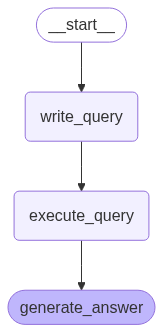

In [12]:
from langgraph.graph import START, StateGraph

# StateGraph 생성
workflow = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)

# 그래프의 시작점(START)과 첫 번째 단계(write_query) 연결
workflow.add_edge(START, "write_query")

# 정의된 단계와 연결 관계를 기반으로 최종 그래프 생성
app = workflow.compile()
app

각 단계를 개별적으로 **스트리밍(stream)** 하여 결과를 확인할 수 있습니다.

In [13]:
for step in app.stream(
    {"question": "직원이 몇명인가요?"},
    stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '직원은 총 8명입니다.'}}


[LangSmith trace](https://smith.langchain.com/o/351c6cd9-1396-5c74-9478-1ee6a22a6433/projects/p/acec9d4d-4978-4597-adff-789cd42e200f?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=2f11a326-ed09-4c35-b057-211164093e1a)를 check해 봅니다.

####  **Human-in-the-loop (인간 개입 단계)**  

- 이 기능을 사용하면 **민감한 단계**(예: SQL 쿼리 실행) 전에 애플리케이션을 **중단(interrupt)** 하고 **사람이 검토(human review)** 할 수 있습니다.  

- 이 기능은 LangGraph의 **[persistence(영속성)](https://langchain-ai.github.io/langgraph/concepts/persistence/)** 레이어를 통해 지원됩니다.  
- 이 레이어는 애플리케이션의 실행 진행 상태(run progress)를 사용자가 선택한 저장소(storage)에 저장합니다.  

아래 예시에서는 **인메모리(in-memory)** 저장소를 지정합니다.

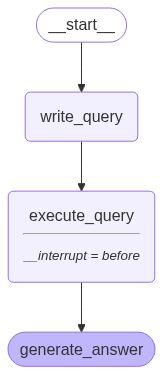

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# 그래프 컴파일 및 중단(interrupt) 지점 설정
# 실행을 중단하여 사람이 검토(human review)할 수 있도록 합니다.
app = workflow.compile(checkpointer=memory, interrupt_before=['execute_query'])
app

In [15]:
# 영속성을 사용할 때는 실행을 이어갈 수 있도록 고유 식별 스레드 ID를 지정
config = {"configurable": {"thread_id": "1"}}

for step in app.stream(
    {"question": "직원이 몇명인가요?"},
    stream_mode="updates",
    config=config
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}}
{'__interrupt__': ()}


----------
동일한 실행(run)을 반복하되, 간단한 **예/아니오(yes/no) 승인 단계**를 추가해보겠습니다.

In [16]:
# 그래프 실행 및 스트림 모드로 단계별 결과 확인
for step in app.stream(
    {"question": "직원이 몇 명 있나요?"},    # 사용자 입력 질문
    config,         # 스레드 ID 및 설정 정보
    stream_mode="updates"  # 단계별 업데이트 결과를 스트리밍 모드로 출력
):
    print(step)  # 각 단계의 결과 출력
    
# execute_query 단계 전에 사용자 승인 여부 확인
try:
    user_approval = input("쿼리를 실행하시겠습니까? (yes/no)")  # 사용자 승인 입력
except Exception:
    user_approval = "no"  # 예외 발생 시 기본값으로 'no' 설정
    
# 승인 확인
if user_approval.lower() == "yes":
    for step in app.stream(
        None,
        config,
        stream_mode="updates"    # 각 단계의 모든 세부 업데이트를 실시간으로 제공
    ):
        print(step)
else:
    # 사용자가 'no'를 입력한 경우, 실행 중단
    print("사용자가 작업을 취소했습니다.")

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}}
{'__interrupt__': ()}


쿼리를 실행하시겠습니까? (yes/no) yes


{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '직원은 총 8명입니다.'}}


##  **2) 에이전트(Agents) 사용 방식**

**에이전트(Agents)** 는 **LLM의 추론(reasoning) 능력**을 활용하여 실행 중에 결정을 내립니다.  
에이전트를 사용하면 **쿼리 생성 및 실행 과정의 추가적인 판단(discretion)** 을 LLM에 맡길 수 있습니다.  

**체인(Chain)** 보다 예측 가능성이 떨어질 수 있지만, 에이전트에는 몇 가지 장점이 있습니다:

- 사용자 질문에 답하기 위해 **필요한 만큼 데이터베이스를 여러 번 쿼리**할 수 있습니다.  
- 생성된 쿼리를 실행하다 오류가 발생하면, **오류(traceback)를 포착**하여 올바르게 **재생성(regenerate)** 할 수 있습니다.  
- 데이터베이스의 **스키마(schema)** 와 **내용(content)** 모두를 기반으로 질문에 답할 수 있습니다 (예: 특정 테이블 설명).  

---

### **SQL 에이전트 구성하기**

아래에서는 최소한의 **SQL 에이전트(SQL Agent)** 를 구성합니다.  
이를 위해 LangChain의 [**SQLDatabaseToolkit**](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html)을 사용하여 도구(tool) 세트를 제공합니다.  

**LangGraph의 [사전 구축된 ReAct 에이전트 생성자(pre-built ReAct agent constructor)](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent)** 를 사용하면 **한 줄의 코드**로 이를 수행할 수 있습니다.

---

`SQLDatabaseToolkit`에는 다음과 같은 도구들이 포함됩니다:

- **쿼리 생성 및 실행(Create and execute queries)**  
- **쿼리 구문 검증(Check query syntax)**  
- **테이블 설명 가져오기(Retrieve table descriptions)**  
- **기타 여러 기능(... and more)**  

In [17]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

# SQLDatabaseToolkit은 LLM과 데이터베이스(SQL)를 연결하기 위한 도구 세트
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# SQLDatabaseToolkit에서 사용할 수 있는 모든 도구를 가져옵니다.
tools = toolkit.get_tools()

# 도구 목록 출력
# tools

In [18]:
tool_names = [tool.name for tool in tools]
tool_names

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

#### **시스템 프롬프트 (System Prompt)**  

에이전트가 올바르게 동작하도록 하기 위해 **시스템 프롬프트(System Prompt)** 를 로드할 필요가 있습니다.   
이를 위해 [**Prompt Hub**](https://smith.langchain.com/hub)에서 sql 생성 **시스템 프롬프트** 를 가져올 것입니다.  
이 프롬프트에는 **에이전트의 행동 지침(instructions for how to behave)** 이 포함됩니다.

In [19]:
from langchain import hub

#  SQL 에이전트를 위한 시스템 프롬프트 템플릿
# 이 템플릿에는 SQL 에이전트가 어떻게 행동해야 하는지에 대한 지침이 포함되어 있습니다.
# prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
# prompt_template = hub.pull("oyj-1/sql-agent-system-prompt-korean")
prompt_template = hub.pull("oyj-1/sql-creation-1")

assert len(prompt_template.messages) == 1

# 프롬프트 내용 출력
prompt_template.messages[0].pretty_print()

================================ System Message ================================

당신은 SQL 전문가입니다. 주어진 질문을 SQL 쿼리로 변환하는 작업을 수행합니다.
    다음 정보를 참고하여 SQL 쿼리를 작성하세요:
    
    방언(dialect): {dialect}
    테이블 정보: {table_info}
    최대 결과 수: {top_k}
    
    쿼리는 문법적으로 정확해야 하며, 질문에 대한 정확한 답을 제공해야 합니다.


프롬프트에서 강조된 **매개변수(parameters)** 를 채워보겠습니다.

In [20]:
system_message = prompt_template.format(dialect="SQLite", table_info=db.get_table_info(), top_k=5)
# system_message

#### **에이전트 초기화 (Initializing Agent)**  

사전 구축된 **LangGraph** 에이전트를 사용하여 **에이전트(agent)** 를 생성합니다.

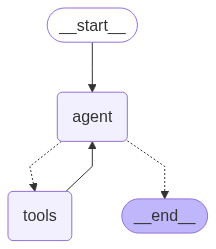

In [21]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# ReAct(Reasoning + Acting) 패턴을 사용하여 에이전트 생성
agent_executor = create_react_agent(
    llm,          # LLM 객체
    tools,        # SQL 쿼리 실행, 스키마 확인 등의 작업을 수행할 수 있는 도구 목록
    state_modifier=system_message
)

agent_executor

In [22]:
question = "직원이 몇명인가요?"

for step in agent_executor.stream(
    {'messages': [{'role': 'user', 'content': question}]},
    stream_mode='values'   #각 단계의 최종 결과 값만 제공
):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

직원이 몇명인가요?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_Xfl1WDhDfPSeIizjHbyRUP12)
 Call ID: call_Xfl1WDhDfPSeIizjHbyRUP12
  Args:
    query: SELECT COUNT(*) AS EmployeeCount FROM Employee;
================================= Tool Message =================================
Name: sql_db_query

[(8,)]
================================== Ai Message ==================================

직원은 총 8명입니다.


In [23]:
question = "어느 나라의 고객이 가장 많은 금액을 지출했나요?"

for step in agent_executor.stream(
    {'messages': [{'role': 'user', 'content': question}]},
    stream_mode='values'   #각 단계의 최종 결과 값만 제공
):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

어느 나라의 고객이 가장 많은 금액을 지출했나요?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_xPxbglAcYFdipK9XGDyBB688)
 Call ID: call_xPxbglAcYFdipK9XGDyBB688
  Args:
    query: SELECT Country, SUM(Total) AS TotalSpent FROM Customer JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId GROUP BY Country ORDER BY TotalSpent DESC LIMIT 1;
  sql_db_query_checker (call_jQSLcZweoQtxCTrDGuV8vGMT)
 Call ID: call_jQSLcZweoQtxCTrDGuV8vGMT
  Args:
    query: SELECT Country, SUM(Total) AS TotalSpent FROM Customer JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId GROUP BY Country ORDER BY TotalSpent DESC LIMIT 1;
================================= Tool Message =================================
Name: sql_db_query_checker

SELECT Country, SUM(Total) AS TotalSpent FROM Customer JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId GROUP BY Country ORDER BY Tota

In [24]:
# SQL 쿼리로 검증
validation_query = """
SELECT BillingCountry, SUM(Total) AS TotalSpent
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSpent DESC
LIMIT 1;
"""

validation_result = db.run(validation_query)
print("검증용 SQL 쿼리 결과:", validation_result)

검증용 SQL 쿼리 결과: [('USA', 523.06)]


[**LangSmith 추적(Trace)**](https://smith.langchain.com/o/351c6cd9-1396-5c74-9478-1ee6a22a6433/projects/p/acec9d4d-4978-4597-adff-789cd42e200f?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=b67c9ebf-e953-4d79-9b34-c0dbbeb921c4)을 사용하여 이러한 단계와 관련 메타데이터를 시각화할 수도 있습니다.

에이전트는 필요한 정보를 얻을 때까지 **여러 번의 쿼리**를 실행한다는 점에 주목하세요:  

1. 사용 가능한 테이블 목록을 나열합니다.  
2. 세 개의 테이블에 대한 스키마를 검색합니다.  
3. 여러 테이블을 **JOIN 연산**을 통해 쿼리합니다.  

에이전트는 마지막 쿼리의 결과를 사용해 **원래 질문에 대한 답변을 생성**할 수 있습니다.

에이전트는 이와 유사하게 **정성적 질문(qualitative questions)** 도 처리할 수 있습니다.

In [25]:
question = "`playlisttrack` 테이블을 설명하세요. 한국어로 설명하세요.**"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

`playlisttrack` 테이블을 설명하세요. 한국어로 설명하세요.**
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_2Xud8DfQD5i8HvQ2xm4zvz9S)
 Call ID: call_2Xud8DfQD5i8HvQ2xm4zvz9S
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES "Playlist" ("PlaylistId")
)

/*
3 rows from PlaylistTrack table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/
================================== Ai Message ==================================

"PlaylistTrack" 테이블은 재생목록(Playlist)과 곡(Track) 간의 관계를 나타내는 연결 테이블입니다. 이 테이블은 각각의 재생목록에 어떤 곡들이 포함되어 있는지를 저장하며, 복수의 곡이 하나의 재생목록에 속하거나, 하

#### **고유 값이 많은(high-cardinality) 열 처리하기**  

주소, 노래 제목, 아티스트와 같은 **고유 명사**를 포함하는 열을 필터링하려면, 먼저 **철자를 확인하여 데이터 필터링을 정확하게 수행해야 합니다**.  

이를 위해, **데이터베이스에 존재하는 모든 고유 명사로 벡터 스토어(vector store)를 생성**할 수 있습니다.  
그 후, **사용자가 질문에 고유 명사를 포함하면, 에이전트가 해당 벡터 스토어를 조회하여 올바른 철자를 찾도록 설정**할 수 있습니다.  

이 방식으로, **에이전트가 사용자가 참조하는 엔티티(entity)를 정확히 이해한 후, 목표 쿼리를 생성할 수 있습니다**.  

먼저, 원하는 엔티티의 **고유 값(유니크 값)** 을 가져오기 위해, 결과를 요소 목록(list)으로 변환하는 함수를 정의해야 합니다.

In [26]:
# import ast

# # 문자열로 반환된 SQL query 결과
# res = "[['Adele'], ['Coldplay'], ['BTS']]"

# print(ast.literal_eval(res))  
# print()

# for sub in ast.literal_eval(res):
#     print(sub)
#     for el in sub:
#         print(el)

# [el for sub in ast.literal_eval(res) for el in sub if el]

In [27]:
import ast  # 문자열을 안전하게 리스트나 딕셔너리로 변환하는 모듈
import re   # 정규 표현식(Regular Expression) 모듈

def query_as_list(db, query):
    """  
    데이터베이스에서 SQL 쿼리를 실행하고, 결과를 리스트 형식으로 변환하는 함수  
    """
    res = db.run(query)  
    # ast.literal_eval()을 사용하여 안전하게 문자열을 리스트로 변환
    # 중첩 리스트를 평탄화(flatten)하면서 None 또는 빈 값 제거
    res = [el for sub in ast.literal_eval(res) for el in sub if el]  
    
    # 숫자(예: 연도, ID 등)를 정규 표현식으로 제거
    # 앞뒤 공백을 제거하여 데이터 정리
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]  
    
    return list(set(res))  # 중복 제거 후 리스트로 변환하여 반환

# 아티스트(Artist) 목록 가져오기
artists = query_as_list(db, "SELECT Name FROM Artist")

# 앨범(Album) 목록 가져오기
albums = query_as_list(db, "SELECT Title FROM Album")

print(artists[:5])
print(albums[:5])

['Van Halen', 'Luiz Melodia', 'Gustavo & Andres Veiga & Salazar', 'Yo-Yo Ma', 'Gilberto Gil']
['Cássia Eller - Coleção Sem Limite [Disc ]', 'The Colour And The Shape', 'No Prayer For The Dying', 'Battlestar Galactica (Classic), Season', 'Radio Brasil (O Som da Jovem Vanguarda) - Seleccao de Henrique Amaro']


이 query_as_list 함수를 사용하여 **에이전트가 필요할 때 실행할 수 있는 검색(retriever) 도구**를 만들 수 있습니다.  

이제 이 단계를 위해 **임베딩 모델과 벡터 스토어를 선택해 보겠습니다.**

In [28]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

이제 **데이터베이스에서 관련된 고유 명사를 검색할 수 있는 검색(retrieval) 도구**를 구성할 수 있습니다.

In [29]:
from langchain.agents.agent_toolkits import create_retriever_tool

# 벡터 스토어에 아티스트 및 앨범 데이터를 추가
_ = vector_store.add_texts(artists + albums)

# 검색 기능을 위한 retriever 객체 생성 (최대 5개 결과 반환)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

# 검색 도구의 설명 설정
description = (
    "필터링할 값을 조회하는 데 사용됩니다. 입력값은 고유 명사의 대략적인 철자이며, "
    "출력값은 올바른 고유 명사입니다. 검색어와 가장 유사한 명사를 사용하세요."
)

# 검색(retrieval) 도구 생성
retriever_tool = create_retriever_tool(
    retriever,  # 벡터 검색 기능을 수행할 retriever 객체
    name="search_proper_nouns",  # 도구의 이름
    description=description,  # 도구 설명
)

In [30]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Jagged Little Pill

Angel Dust

Amy Winehouse


<br>
이렇게 하면 에이전트가 "Alice Chains"와 같은 아티스트를 기반으로 필터를 작성해야 한다고 판단할 경우, 먼저 검색 도구(retriever tool)를 사용하여 해당 열의 관련된 값을 확인할 수 있습니다.

이제 이를 하나로 정리해 봅니다.

In [31]:
#system_message
#tools

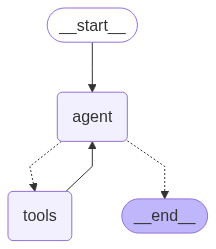

In [32]:
# 시스템 메시지에 추가할 내용
suffix = (
    "이름과 같은 고유 명사로 필터링해야 할 경우, 반드시 먼저 'search_proper_nouns' 도구를 사용하여 "
    "필터 값을 조회해야 합니다! 올바른 이름을 추측하려 하지 말고, 이 함수를 사용하여 유사한 이름을 찾으세요."
)

# 기존 시스템 메시지에 새로운 규칙 추가
system = f"{system_message}\n\n{suffix}"

# 도구 리스트에 검색 도구(retriever tool) 추가
tools.append(retriever_tool)

# ReAct 기반 에이전트 생성
agent = create_react_agent(llm, tools, state_modifier=system)
agent

In [33]:
# tools[5]

In [34]:
question = "AAlice In CChainNs는 몇 개의 앨범을 보유하고 있나요?"  

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},  
    stream_mode="values", 
):
    step["messages"][-1].pretty_print()  

================================ Human Message =================================

AAlice In CChainNs는 몇 개의 앨범을 보유하고 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (call_j9tmfriK3Nn6RhxEfaDNu8s4)
 Call ID: call_j9tmfriK3Nn6RhxEfaDNu8s4
  Args:
    query: AAlice In CChainNs
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

Brave New World

One By One

Somewhere in Time

Cake
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_1PrEP3vmd8e6whogJWZ510e3)
 Call ID: call_1PrEP3vmd8e6whogJWZ510e3
  Args:
    query: SELECT COUNT(*) FROM Album WHERE Title = 'Alice In Chains';
================================= Tool Message =================================
Name: sql_db_query

[(0,)]
================================== Ai Message ==================================

"AAlice In CChainNs"라는 이름의 